In [47]:
import numpy as np
import arepo
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from tqdm import tqdm
import matplotlib as mpl
from scipy.stats import binned_statistic_2d
from numba import njit
import h5py as h5
import os
from scipy.signal import argrelextrema
from mpl_toolkits.axes_grid1 import ImageGrid

In [2]:
basepath = '/n/holylfs05/LABS/hernquist_lab/Users/abeane/GSEgas/'

In [3]:
sn = {}
sn_iso = {}
num_list = [0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400,
           425, 450, 475, 500, 525, 550, 575, 600, 625, 650, 675, 700, 725, 750, 775, 800]
for num in tqdm(num_list):
    sn[num] = arepo.Snapshot(basepath + 'runs/MW4_MHG0.25_GSE2_MHG0.5/lvl4/output', num, parttype=0,
                             fields = ['Coordinates', 'Velocities', 'Masses'],
                             combineFiles=True)
    sn_iso[num] = arepo.Snapshot(basepath + 'runs/MW4iso_fg0.2_MHG0.25_RC9/lvl4/output', num, parttype=0,
                             fields = ['Coordinates', 'Velocities', 'Masses'],
                                    combineFiles=True)

100%|██████████| 33/33 [02:11<00:00,  3.97s/it]


In [33]:
name = 'MW4iso_fg0.2_MHG0.25_RC9-lvl4'
COM_fpath = basepath + 'anlys/COM/COM_' + name + '.npy'
COM_iso = np.load(COM_fpath, allow_pickle=True).item()

name = 'MW4_MHG0.25_GSE2_MHG0.5-lvl4'
COM_fpath = basepath + 'anlys/COM/COM_' + name + '.npy'
COM = np.load(COM_fpath, allow_pickle=True).item()

In [5]:
def accretion_rate(sn, r0, dr, COM, COMV):
    
    pos = sn.part0.pos.value - COM
    vel = sn.part0.vel.value - COMV
    mass = sn.part0.mass.value
    
    r = np.linalg.norm(pos, axis=1)
    R = np.linalg.norm(pos[:,:2], axis=1)
    cphi = pos[:,0]/R
    sphi = pos[:,1]/R
    ctheta = pos[:,2]/r
    stheta = np.sqrt(1 - ctheta**2)
    
    vr = stheta * cphi * vel[:,0] + stheta * sphi * vel[:,1] + ctheta * vel[:,2]
    
    key = np.logical_and(r > r0 - dr/2., r < r0 + dr/2.)
    keyin = np.logical_and(key, vr < 0)
    keyout = np.logical_and(key, vr > 0)
    
    Mdotin = np.sum(mass[keyin] * vr[keyin]) / dr
    Mdotout = np.sum(mass[keyout] * vr[keyout]) / dr
    
    return Mdotin, Mdotout
    

In [8]:
inflow_iso = []
inflow = []

outflow_iso = []
outflow = []

Time = []

dr_ = 2

for num in num_list[:-1]:
    Mdotin, Mdotout = accretion_rate(sn[num], 40, dr_, COM['MW_COM'][num], COM['MW_COMV'][num])
    inflow.append(Mdotin)
    outflow.append(Mdotout)
    
    Mdotin, Mdotout = accretion_rate(sn_iso[num], 40, dr_, COM_iso['MW_COM'][num], COM_iso['MW_COMV'][num])
    inflow_iso.append(Mdotin)
    outflow_iso.append(Mdotout)
    
    Time.append(sn[num].Time.value)

inflow_iso = np.array(inflow_iso)
inflow = np.array(inflow)

outflow_iso = np.array(outflow_iso)
outflow = np.array(outflow)

Time = np.array(Time)
    

-1.0152937006244647
-1.2370534935900594


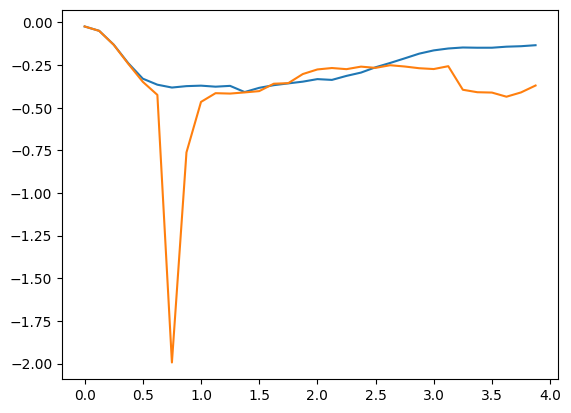

In [9]:
plt.plot(Time, inflow_iso)
plt.plot(Time, inflow)

print(np.trapz(inflow_iso+outflow_iso, Time))
print(np.trapz(inflow+outflow, Time))

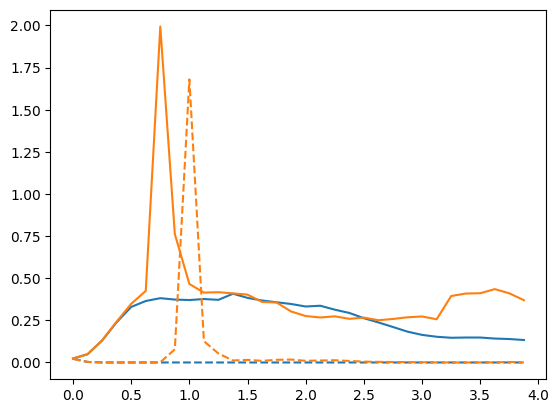

In [10]:
l = plt.plot(Time, -inflow_iso)
plt.plot(Time, outflow_iso, c=l[0].get_color(), ls='dashed')

l = plt.plot(Time, -inflow)
plt.plot(Time, outflow, c=l[0].get_color(), ls='dashed')

In [87]:
inflow[25]

-0.8493619602509289

In [88]:
num_list[25]

625

In [89]:
rGSE = np.linalg.norm(COM['GSE_COM'] - COM['MW_COM'], axis=1)
print(rGSE[625])

35.56363456887197


In [73]:
print(inflow[6])
print(rGSE[num_list[6]])

-0.7667242885506602
35.51181627468381


### using tracers

In [11]:
def accretion_rate(name, snap, r0, dr):
    fname = basepath + 'anlys/MC/'+name+'/MC_Prop_'+str(snap).zfill(3)+'.h5'
    f = h5.File(fname, mode='r')
    
    pos = f['PartType5/RotatedCoordinates'][:]
    vel = f['PartType5/RotatedVelocities'][:]
    memb = f['PartType5/Membership'][:]
    mass = f['Header'].attrs['TracerMass']
    
    r = np.linalg.norm(pos, axis=1)
    R = np.linalg.norm(pos[:,:2], axis=1)
    cphi = pos[:,0]/R
    sphi = pos[:,1]/R
    ctheta = pos[:,2]/r
    stheta = np.sqrt(1 - ctheta**2)
    
    vr = stheta * cphi * vel[:,0] + stheta * sphi * vel[:,1] + ctheta * vel[:,2]
    
    key = np.logical_and(r > r0 - dr/2., r < r0 + dr/2.)
    key = np.logical_and(key, memb==1)
    keyin = np.logical_and(key, vr < 0)
    keyout = np.logical_and(key, vr > 0)
    
    Mdotin = np.sum(mass * vr[keyin]) / dr
    Mdotout = np.sum(mass * vr[keyout]) / dr
    
    return Mdotin, Mdotout
    

In [12]:
nameiso = 'MW4iso_fg0.2_MHG0.25_RC9-lvl4'
name = 'MW4_MHG0.25_GSE2_MHG0.5-lvl4'
# namekick = 'MW3_MHG0.25_GSE6_kick-lvl4'


In [13]:
inflow = {}
inflow[nameiso] = []
inflow[name] = []
# inflow[namekick] = []

outflow = {}
outflow[nameiso] = []
outflow[name] = []
# outflow[namekick] = []

r0 = 20

idx_list = np.arange(0, 800, 10)
for idx in tqdm(idx_list):
    try:
        in_, out_ = accretion_rate(nameiso, idx, r0, 2)
        inflow[nameiso].append(in_)
        outflow[nameiso].append(out_)
    except:
        pass
    
    try:
        in_, out_ = accretion_rate(name, idx, r0, 2)
        inflow[name].append(in_)
        outflow[name].append(out_)
    except:
        pass
    
    try:
        in_, out_ = accretion_rate(namekick, idx, r0, 2)
        inflow[namekick].append(in_)
        outflow[namekick].append(out_)
    except:
        pass

100%|██████████| 80/80 [01:13<00:00,  1.08it/s]


630


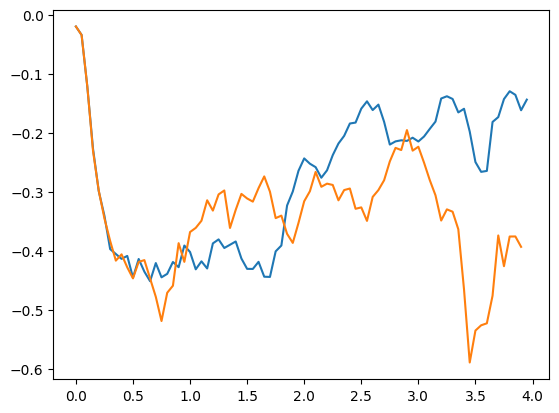

In [17]:
plt.plot(idx_list/200, inflow[nameiso])
# print(len(inflow[name]), len(idx_list))
# print(len(inflow[namekick]))
plt.plot(idx_list[:-1]/200, inflow[name])
# l = plt.plot(idx_list/200, inflow[namekick])


# print(minima[0])
# plt.axvline(COM['Time'][minima[0][0]], c=l[0].get_color(), ls='dashed')
# plt.axvline(COM['Time'][minima[0][1]], c=l[0].get_color(), ls='dashed')
# plt.axvline(COM['Time'][minima[0][2]], c=l[0].get_color(), ls='dashed')

# plt.axvline(idx_list[63]/200)
print(idx_list[63])


In [39]:
menc_iso = np.trapz(inflow[nameiso], idx_list/200)
menc_N = np.trapz(inflow[name], idx_list/200)
menc_kick = np.trapz(inflow[namekick], idx_list/200)

print('iso', menc_iso)
print('Nbody', menc_N)
print('kick', menc_kick)

iso -1.184429590424593
Nbody -1.513965242763382
kick -1.2639974239429406


In [34]:
len(idx_list)

80

In [129]:
print(inflow[namekick][14])
print(idx_list[14])

-1.6162234637101247
140


## r-vr plot at idx=140

In [43]:
# nameiso = 'MW3iso_fg0.7_MHG0.25_RC9-lvl4'
# name = 'MW3_MHG0.25_GSE2N-lvl4'
# namekick = 'MW3_MHG0.25_GSE6_kick-lvl4'
nameiso = 'MW4iso_fg0.2_MHG0.25_RC9-lvl4'
name = 'MW4_MHG0.25_GSE2_MHG0.5-lvl4'

snap=140

fname = basepath + 'anlys/MC/'+name+'/MC_Prop_'+str(snap).zfill(3)+'.h5'
f = h5.File(fname, mode='r')
print(f['Header'].attrs.keys())


<KeysViewHDF5 ['Time', 'TracerMass']>


In [44]:
def get_r_vr(name, snap):
    fname = basepath + 'anlys/MC/'+name+'/MC_Prop_'+str(snap).zfill(3)+'.h5'
    f = h5.File(fname, mode='r')

    pos = f['PartType5/RotatedCoordinates'][:]
    vel = f['PartType5/RotatedVelocities'][:]
    memb = f['PartType5/Membership'][:]
    mass = f['Header'].attrs['TracerMass']
    T = f['PartType5/Temperature'][:]
    
    r = np.linalg.norm(pos, axis=1)
    R = np.linalg.norm(pos[:,:2], axis=1)
    cphi = pos[:,0]/R
    sphi = pos[:,1]/R
    ctheta = pos[:,2]/r
    stheta = np.sqrt(1 - ctheta**2)
    
    vr = stheta * cphi * vel[:,0] + stheta * sphi * vel[:,1] + ctheta * vel[:,2]
    
    return r[memb==1], vr[memb==1], T[memb==1], mass

In [45]:
def get_pos(name, snap):
    fname = basepath + 'anlys/MC/'+name+'/MC_Prop_'+str(snap).zfill(3)+'.h5'
    f = h5.File(fname, mode='r')

    pos = f['PartType5/RotatedCoordinates'][:]
    vel = f['PartType5/RotatedVelocities'][:]
    memb = f['PartType5/Membership'][:]
    mass = f['Header'].attrs['TracerMass']
    T = f['PartType5/Temperature'][:]
    
    r = np.linalg.norm(pos, axis=1)
    R = np.linalg.norm(pos[:,:2], axis=1)
    cphi = pos[:,0]/R
    sphi = pos[:,1]/R
    ctheta = pos[:,2]/r
    stheta = np.sqrt(1 - ctheta**2)
    
    vr = stheta * cphi * vel[:,0] + stheta * sphi * vel[:,1] + ctheta * vel[:,2]
    
    # return r[memb==1], vr[memb==1], T[memb==1]
    return pos[memb==1], T[memb==1]

Text(0.5, 1.0, 'merger')

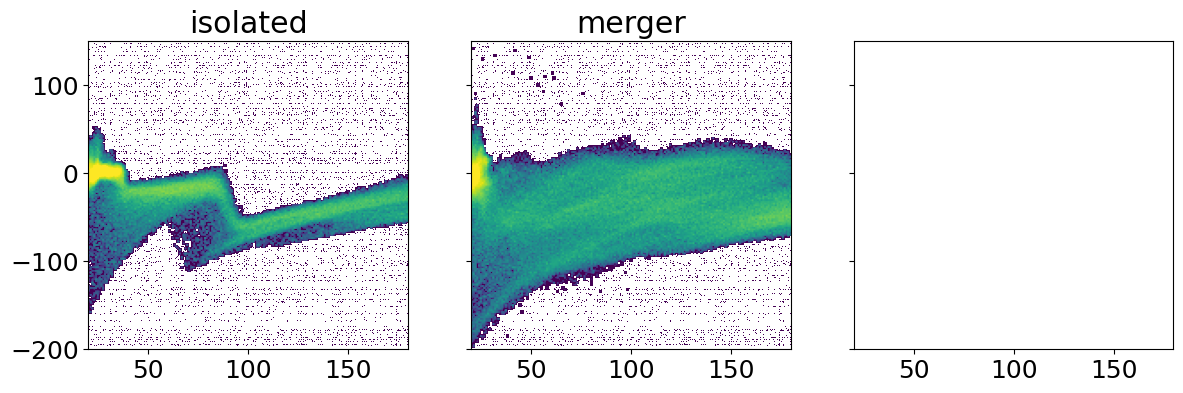

In [60]:
snap = 800

vmin = 8.7E-7
vmax = 8.7E-4
# print(vmin, vmax)

fig, ax = plt.subplots(1, 3, figsize=(14, 4), sharex=True, sharey=True)

rbins = np.linspace(20, 180, 180)
vrbins = np.linspace(-200, 150, 180)
extent = [rbins[0], rbins[-1], vrbins[0], vrbins[-1]]

dr = (rbins[-1]-rbins[0])/len(rbins)
dvr = (vrbins[-1]-vrbins[0])/len(vrbins)

# print(dr, dvr, dr*dvr, vmin/dr/dvr, vmax/dr/dvr)

r, vr, T, mass = get_r_vr(nameiso, snap)
m = np.full(len(r), mass/dr/dvr)
m_in_bin, x_edge, y_edge, _ = binned_statistic_2d(r, vr, m,
                                                  statistic='sum', bins=(rbins, vrbins))
im = ax[0].imshow(m_in_bin.T, origin='lower', norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax), extent=extent)
ax[0].set_aspect('auto')
ax[0].set_title('isolated')
# fig.colorbar(im, ax=ax[0])

r, vr, T, mass = get_r_vr(name, snap)
m = np.full(len(r), mass/dr/dvr)
m_in_bin, x_edge, y_edge, _ = binned_statistic_2d(r, vr, m,
                                                  statistic='sum', bins=(rbins, vrbins))
im = ax[1].imshow(m_in_bin.T, origin='lower', norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax), extent=extent)
ax[1].set_aspect('auto')
ax[1].set_title('merger')
# fig.colorbar(im, ax=ax[1])

# r, vr, T, mass = get_r_vr(namekick, snap)
# m = np.full(len(r), mass/dr/dvr)
# m_in_bin, x_edge, y_edge, _ = binned_statistic_2d(r, vr, m,
#                                                   statistic='sum', bins=(rbins, vrbins))
# im = ax[2].imshow(m_in_bin.T, origin='lower', norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax), extent=extent)
# ax[2].set_aspect('auto')
# ax[2].set_title('gas satellite stripping')
# fig.colorbar(im, ax=ax[2])


/tmp/ipykernel_2328128/2139997693.py:27: RuntimeWarning: invalid value encountered in log10
  m_in_bin, x_edge, y_edge, _ = binned_statistic_2d(r, vr, np.log10(T),
/tmp/ipykernel_2328128/2139997693.py:35: RuntimeWarning: invalid value encountered in log10
  m_in_bin, x_edge, y_edge, _ = binned_statistic_2d(r, vr, np.log10(T),


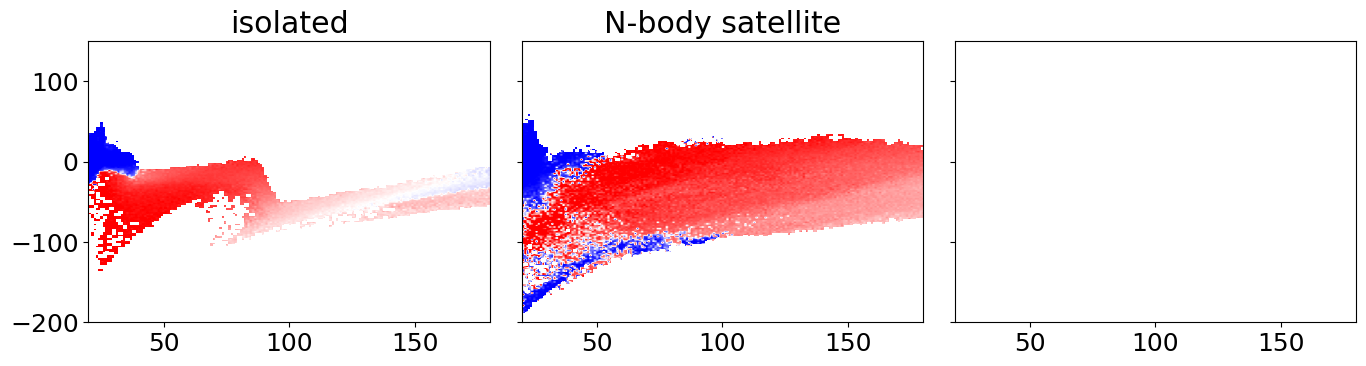

In [53]:
snap = 800

from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.close()
fig, ax = plt.subplots(1, 3, figsize=(14, 4), sharex=True, sharey=True)

# fig = plt.figure(figsize=(20, 4))
# grid = ImageGrid(fig, 131,
                # nrows_ncols = (1,3),
                # axes_pad = 0.2,
                # cbar_location = "right",
                # cbar_mode="single",
                # cbar_size="5%",
                # cbar_pad=0.05
                # )

vmin = 4
vmax = 5.5

rbins = np.linspace(20, 180, 180)
vrbins = np.linspace(-200, 150, 180)
extent = [rbins[0], rbins[-1], vrbins[0], vrbins[-1]]

r, vr, T, mass = get_r_vr(nameiso, snap)
m = np.full(len(r), mass)
m_in_bin, x_edge, y_edge, _ = binned_statistic_2d(r, vr, np.log10(T),
                                                  statistic='median', bins=(rbins, vrbins))
im0 = ax[0].imshow(m_in_bin.T, origin='lower', extent=extent, cmap='bwr', vmin=vmin, vmax=vmax)
ax[0].set_aspect('auto')
ax[0].set_title('isolated')

r, vr, T, mass = get_r_vr(name, snap)
m = np.full(len(r), mass)
m_in_bin, x_edge, y_edge, _ = binned_statistic_2d(r, vr, np.log10(T),
                                                  statistic='median', bins=(rbins, vrbins))
im1 = ax[1].imshow(m_in_bin.T, origin='lower', extent=extent, cmap='bwr', vmin=vmin, vmax=vmax)
ax[1].set_aspect('auto')
ax[1].set_title('N-body satellite')

# r, vr, T = get_r_vr(namekick, snap)
# m = np.full(len(r), mass)
# m_in_bin, x_edge, y_edge, _ = binned_statistic_2d(r, vr, np.log10(T),
#                                                   statistic='median', bins=(rbins, vrbins))
# im2 = ax[2].imshow(m_in_bin.T, origin='lower', extent=extent, cmap='bwr', vmin=vmin, vmax=vmax)
# ax[2].set_aspect('auto')
# ax[2].set_title('gas satellite stripping')

# divider = make_axes_locatable(ax[2])
# cax = divider.append_axes('right', size='5%', pad=0.05)

# fig.colorbar(im2, cax=cax)

fig.tight_layout()

/tmp/ipykernel_2328128/3764212626.py:20: RuntimeWarning: invalid value encountered in log10
  m_in_bin, x_edge, y_edge, _ = binned_statistic_2d(r, np.log10(T), m,
/tmp/ipykernel_2328128/3764212626.py:29: RuntimeWarning: invalid value encountered in log10
  m_in_bin, x_edge, y_edge, _ = binned_statistic_2d(r, np.log10(T), m,


Text(0.5, 1.0, 'merger')

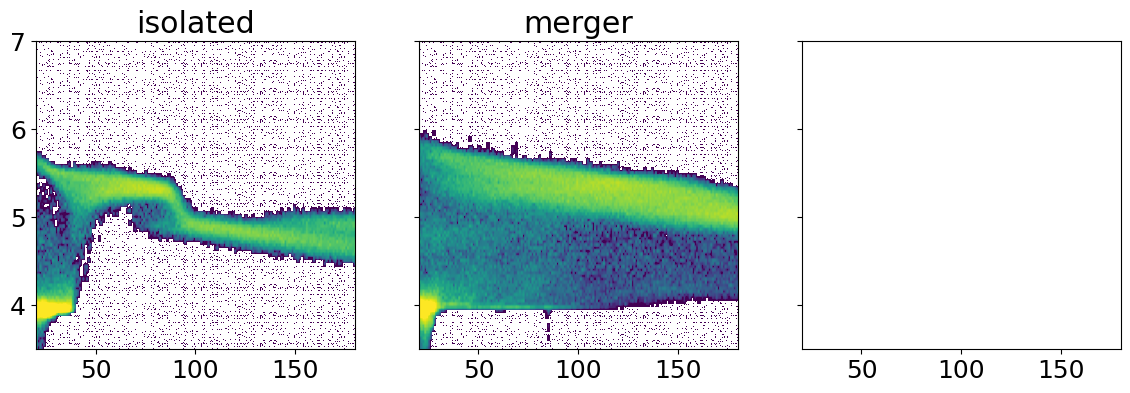

In [61]:
snap = 800

vmin = 8.7E-7
vmax = 8.7E-4
# print(vmin, vmax)

fig, ax = plt.subplots(1, 3, figsize=(14, 4), sharex=True, sharey=True)

rbins = np.linspace(20, 180, 180)
Tbins = np.linspace(3.5, 7, 100)
extent = [rbins[0], rbins[-1], Tbins[0], Tbins[-1]]

dr = (rbins[-1]-rbins[0])/len(rbins)
dT = (Tbins[-1]-Tbins[0])/len(Tbins)

# print(dr, dvr, dr*dvr, vmin/dr/dvr, vmax/dr/dvr)

r, vr, T, mass = get_r_vr(nameiso, snap)
m = np.full(len(r), mass/dr/dvr)
m_in_bin, x_edge, y_edge, _ = binned_statistic_2d(r, np.log10(T), m,
                                                  statistic='sum', bins=(rbins, Tbins))
im = ax[0].imshow(m_in_bin.T, origin='lower', norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax), extent=extent)
ax[0].set_aspect('auto')
ax[0].set_title('isolated')
# fig.colorbar(im, ax=ax[0])

r, vr, T, mass = get_r_vr(name, snap)
m = np.full(len(r), mass/dr/dvr)
m_in_bin, x_edge, y_edge, _ = binned_statistic_2d(r, np.log10(T), m,
                                                  statistic='sum', bins=(rbins, Tbins))
im = ax[1].imshow(m_in_bin.T, origin='lower', norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax), extent=extent)
ax[1].set_aspect('auto')
ax[1].set_title('merger')
# fig.colorbar(im, ax=ax[1])

# r, vr, T, mass = get_r_vr(namekick, snap)
# m = np.full(len(r), mass/dr/dvr)
# m_in_bin, x_edge, y_edge, _ = binned_statistic_2d(r, vr, m,
#                                                   statistic='sum', bins=(rbins, vrbins))
# im = ax[2].imshow(m_in_bin.T, origin='lower', norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax), extent=extent)
# ax[2].set_aspect('auto')
# ax[2].set_title('gas satellite stripping')
# fig.colorbar(im, ax=ax[2])


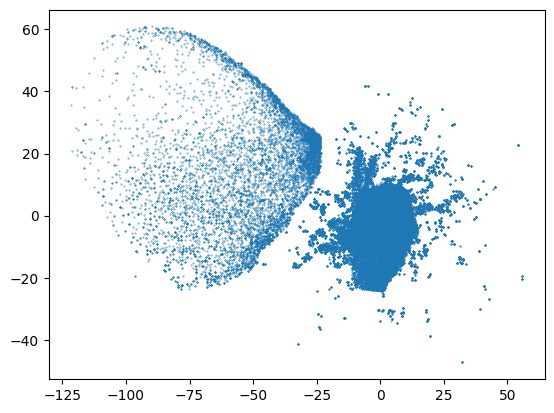

In [279]:
snap = 140
pos, T = get_pos(namekick, snap)

plt.scatter(pos[:,0][T < 3E4], pos[:,1][T < 3E4], s=0.1)

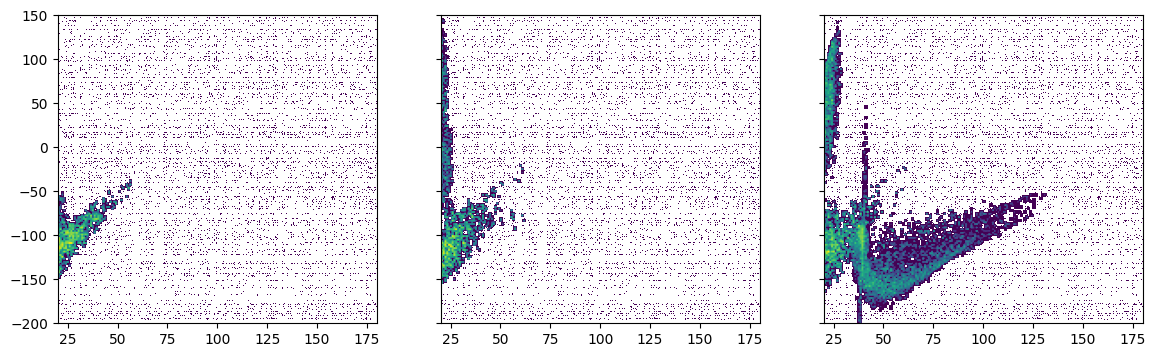

In [185]:
snap = 140

fig, ax = plt.subplots(1, 3, figsize=(14, 4), sharex=True, sharey=True)

rbins = np.linspace(20, 180, 180)
vrbins = np.linspace(-200, 150, 180)
extent = [rbins[0], rbins[-1], vrbins[0], vrbins[-1]]

r, vr, T = get_r_vr(nameiso, snap)
m = np.full(len(r), mass)
m_in_bin, x_edge, y_edge, _ = binned_statistic_2d(r[T < 3E4], vr[T < 3E4], m[T < 3E4],
                                                  statistic='sum', bins=(rbins, vrbins))
ax[0].imshow(m_in_bin.T, origin='lower', norm=mpl.colors.LogNorm(), extent=extent)
ax[0].set_aspect('auto')

r, vr, T = get_r_vr(name, snap)
m = np.full(len(r), mass)
m_in_bin, x_edge, y_edge, _ = binned_statistic_2d(r[T < 3E4], vr[T < 3E4], m[T < 3E4],
                                                  statistic='sum', bins=(rbins, vrbins))
ax[1].imshow(m_in_bin.T, origin='lower', norm=mpl.colors.LogNorm(), extent=extent)
ax[1].set_aspect('auto')

r, vr, T = get_r_vr(namekick, snap)
m = np.full(len(r), mass)
m_in_bin, x_edge, y_edge, _ = binned_statistic_2d(r[T < 3E4], vr[T < 3E4], m[T < 3E4],
                                                  statistic='sum', bins=(rbins, vrbins))
ax[2].imshow(m_in_bin.T, origin='lower', norm=mpl.colors.LogNorm(), extent=extent)
ax[2].set_aspect('auto')


Text(0.5, 1.0, 'gas satellite stripping')

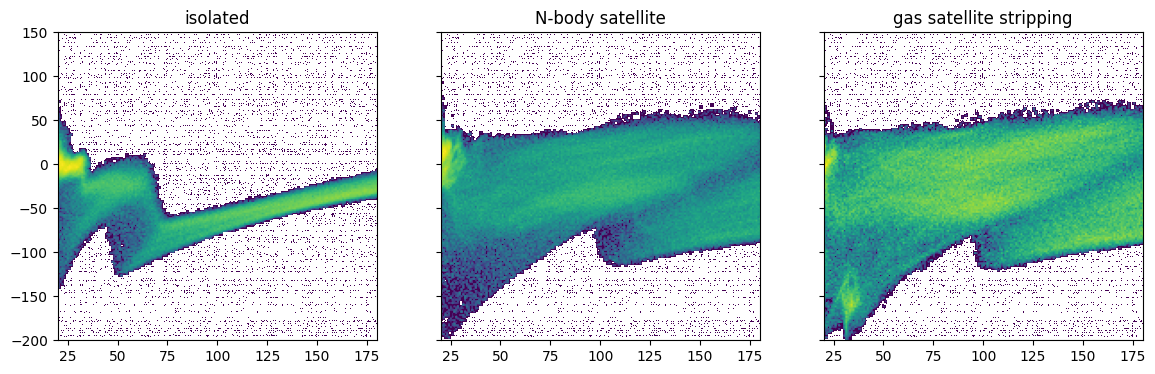

In [196]:
snap = 630

fig, ax = plt.subplots(1, 3, figsize=(14, 4), sharex=True, sharey=True)

rbins = np.linspace(20, 180, 180)
vrbins = np.linspace(-200, 150, 180)
extent = [rbins[0], rbins[-1], vrbins[0], vrbins[-1]]

r, vr, T = get_r_vr(nameiso, snap)
m = np.full(len(r), mass)
m_in_bin, x_edge, y_edge, _ = binned_statistic_2d(r, vr, m,
                                                  statistic='sum', bins=(rbins, vrbins))
ax[0].imshow(m_in_bin.T, origin='lower', norm=mpl.colors.LogNorm(), extent=extent)
ax[0].set_aspect('auto')
ax[0].set_title('isolated')

r, vr, T = get_r_vr(name, snap)
m = np.full(len(r), mass)
m_in_bin, x_edge, y_edge, _ = binned_statistic_2d(r, vr, m,
                                                  statistic='sum', bins=(rbins, vrbins))
ax[1].imshow(m_in_bin.T, origin='lower', norm=mpl.colors.LogNorm(), extent=extent)
ax[1].set_aspect('auto')
ax[1].set_title('N-body satellite')

r, vr, T = get_r_vr(namekick, snap)
m = np.full(len(r), mass)
m_in_bin, x_edge, y_edge, _ = binned_statistic_2d(r, vr, m,
                                                  statistic='sum', bins=(rbins, vrbins))
ax[2].imshow(m_in_bin.T, origin='lower', norm=mpl.colors.LogNorm(), extent=extent)
ax[2].set_aspect('auto')
ax[2].set_title('gas satellite stripping')


Text(0.5, 1.0, 'gas satellite stripping')

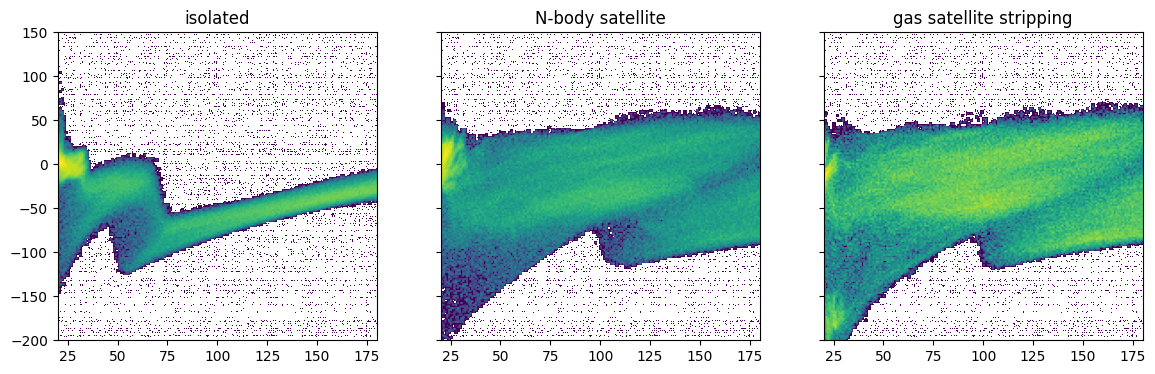

In [197]:
snap = 640

fig, ax = plt.subplots(1, 3, figsize=(14, 4), sharex=True, sharey=True)

rbins = np.linspace(20, 180, 180)
vrbins = np.linspace(-200, 150, 180)
extent = [rbins[0], rbins[-1], vrbins[0], vrbins[-1]]

r, vr, T = get_r_vr(nameiso, snap)
m = np.full(len(r), mass)
m_in_bin, x_edge, y_edge, _ = binned_statistic_2d(r, vr, m,
                                                  statistic='sum', bins=(rbins, vrbins))
ax[0].imshow(m_in_bin.T, origin='lower', norm=mpl.colors.LogNorm(), extent=extent)
ax[0].set_aspect('auto')
ax[0].set_title('isolated')

r, vr, T = get_r_vr(name, snap)
m = np.full(len(r), mass)
m_in_bin, x_edge, y_edge, _ = binned_statistic_2d(r, vr, m,
                                                  statistic='sum', bins=(rbins, vrbins))
ax[1].imshow(m_in_bin.T, origin='lower', norm=mpl.colors.LogNorm(), extent=extent)
ax[1].set_aspect('auto')
ax[1].set_title('N-body satellite')

r, vr, T = get_r_vr(namekick, snap)
m = np.full(len(r), mass)
m_in_bin, x_edge, y_edge, _ = binned_statistic_2d(r, vr, m,
                                                  statistic='sum', bins=(rbins, vrbins))
ax[2].imshow(m_in_bin.T, origin='lower', norm=mpl.colors.LogNorm(), extent=extent)
ax[2].set_aspect('auto')
ax[2].set_title('gas satellite stripping')


Text(0.5, 1.0, 'gas satellite stripping')

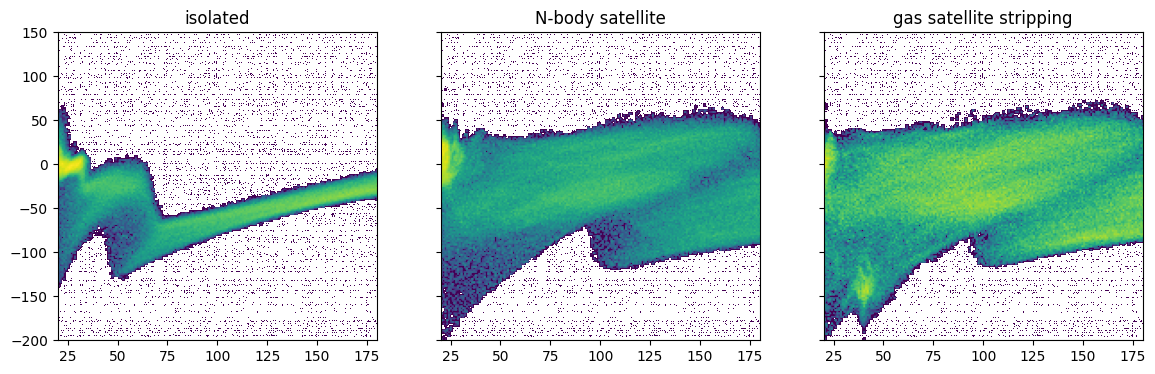

In [198]:
snap = 620

fig, ax = plt.subplots(1, 3, figsize=(14, 4), sharex=True, sharey=True)

rbins = np.linspace(20, 180, 180)
vrbins = np.linspace(-200, 150, 180)
extent = [rbins[0], rbins[-1], vrbins[0], vrbins[-1]]

r, vr, T = get_r_vr(nameiso, snap)
m = np.full(len(r), mass)
m_in_bin, x_edge, y_edge, _ = binned_statistic_2d(r, vr, m,
                                                  statistic='sum', bins=(rbins, vrbins))
ax[0].imshow(m_in_bin.T, origin='lower', norm=mpl.colors.LogNorm(), extent=extent)
ax[0].set_aspect('auto')
ax[0].set_title('isolated')

r, vr, T = get_r_vr(name, snap)
m = np.full(len(r), mass)
m_in_bin, x_edge, y_edge, _ = binned_statistic_2d(r, vr, m,
                                                  statistic='sum', bins=(rbins, vrbins))
ax[1].imshow(m_in_bin.T, origin='lower', norm=mpl.colors.LogNorm(), extent=extent)
ax[1].set_aspect('auto')
ax[1].set_title('N-body satellite')

r, vr, T = get_r_vr(namekick, snap)
m = np.full(len(r), mass)
m_in_bin, x_edge, y_edge, _ = binned_statistic_2d(r, vr, m,
                                                  statistic='sum', bins=(rbins, vrbins))
ax[2].imshow(m_in_bin.T, origin='lower', norm=mpl.colors.LogNorm(), extent=extent)
ax[2].set_aspect('auto')
ax[2].set_title('gas satellite stripping')


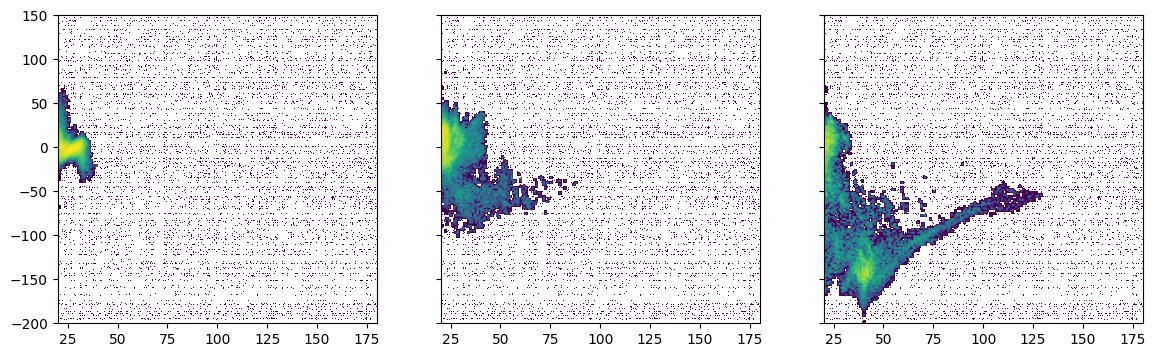

In [199]:
snap = 620

fig, ax = plt.subplots(1, 3, figsize=(14, 4), sharex=True, sharey=True)

rbins = np.linspace(20, 180, 180)
vrbins = np.linspace(-200, 150, 180)
extent = [rbins[0], rbins[-1], vrbins[0], vrbins[-1]]

r, vr, T = get_r_vr(nameiso, snap)
m = np.full(len(r), mass)
m_in_bin, x_edge, y_edge, _ = binned_statistic_2d(r[T < 3E4], vr[T < 3E4], m[T < 3E4],
                                                  statistic='sum', bins=(rbins, vrbins))
ax[0].imshow(m_in_bin.T, origin='lower', norm=mpl.colors.LogNorm(), extent=extent)
ax[0].set_aspect('auto')

r, vr, T = get_r_vr(name, snap)
m = np.full(len(r), mass)
m_in_bin, x_edge, y_edge, _ = binned_statistic_2d(r[T < 3E4], vr[T < 3E4], m[T < 3E4],
                                                  statistic='sum', bins=(rbins, vrbins))
ax[1].imshow(m_in_bin.T, origin='lower', norm=mpl.colors.LogNorm(), extent=extent)
ax[1].set_aspect('auto')

r, vr, T = get_r_vr(namekick, snap)
m = np.full(len(r), mass)
m_in_bin, x_edge, y_edge, _ = binned_statistic_2d(r[T < 3E4], vr[T < 3E4], m[T < 3E4],
                                                  statistic='sum', bins=(rbins, vrbins))
ax[2].imshow(m_in_bin.T, origin='lower', norm=mpl.colors.LogNorm(), extent=extent)
ax[2].set_aspect('auto')


### surf profile of kick

In [134]:
def get_dens_prof(name, snap):
    fname = basepath + 'anlys/MC/'+name+'/MC_Prop_'+str(snap).zfill(3)+'.h5'
    f = h5.File(fname, mode='r')
    
    pos = f['PartType5/RotatedCoordinates'][:]
    memb = f['PartType5/Membership'][:]
    mass = f['Header'].attrs['TracerMass']
    r = np.linalg.norm(pos, axis=1)
    
    rmin = 0.
    rmax = 200.
    dr = 3.
    
    rho = []
    aver = []
    
    while rmin < rmax:
        key = np.logical_and(r > rmin, r < rmin + dr)
        key = np.logical_and(key, memb==1)
        
        Menc = mass * len(np.where(key)[0])
        vol = (4*np.pi/3.) * ((rmin + dr)**3 - rmin**3)
        
        rho.append(Menc/vol)
        aver.append(np.mean(r[key]))
        
        rmin += dr
    
    rho = np.array(rho)
    aver = np.array(aver)
    
    return aver, rho

In [146]:
snap = 400
rkick, rhokick = get_dens_prof(namekick, snap)
riso, rhoiso = get_dens_prof(nameiso, snap)
r, rho = get_dens_prof(name, snap)

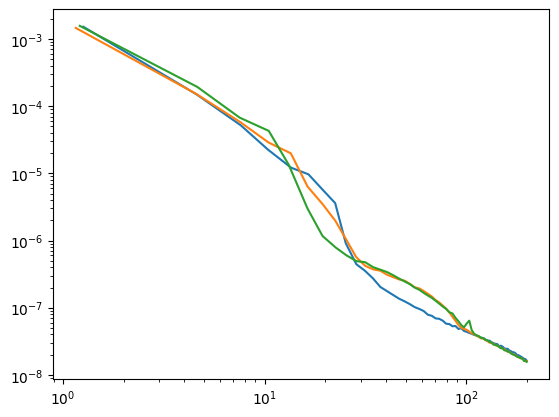

In [147]:
plt.plot(riso, rhoiso)
plt.plot(r, rho)
plt.plot(rkick, rhokick)
plt.yscale('log')
plt.xscale('log')

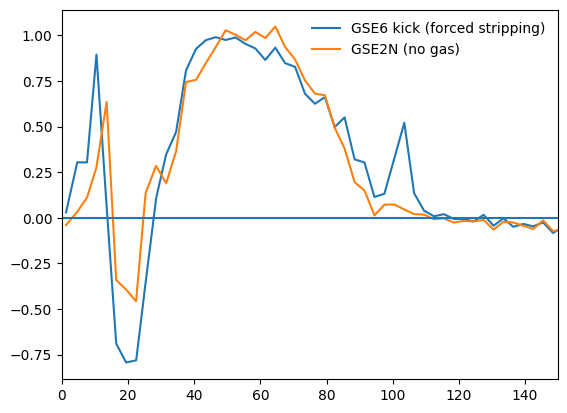

In [149]:
# plt.plot(riso, rhoiso)
# plt.plot(r, rho)
plt.plot((rkick+riso)/2., (rhokick-rhoiso)/rhoiso, label='GSE6 kick (forced stripping)')
plt.plot((r+riso)/2., (rho-rhoiso)/rhoiso, label='GSE2N (no gas)')
plt.xlim(0, 150)
plt.axhline(0)
plt.legend(frameon=False)
# plt.yscale('log')
# plt.xscale('log')

## average accretion rate

In [231]:
def mean_accretion(name, snap0, snap1, rcut=40):
    fname = basepath + 'anlys/MC/'+name+'/MC_Prop_'+str(snap0).zfill(3)+'.h5'
    f0 = h5.File(fname, mode='r')
    
    fname = basepath + 'anlys/MC/'+name+'/MC_Prop_'+str(snap1).zfill(3)+'.h5'
    f1 = h5.File(fname, mode='r')
    
    r0 = np.linalg.norm(f0['PartType5/RotatedCoordinates'][:], axis=1)
    r1 = np.linalg.norm(f1['PartType5/RotatedCoordinates'][:], axis=1)
    
    memb0 = f0['PartType5/Membership'][:]
    memb1 = f1['PartType5/Membership'][:]
    
    mass0 = f0['Header'].attrs['TracerMass']
    mass1 = f1['Header'].attrs['TracerMass']
    
    enc0 = np.logical_and(r0 < rcut, memb0 == 1)
    enc1 = np.logical_and(r1 < rcut, memb1 == 1)
    
    Menc0 = mass0 * len(np.where(enc0)[0])
    Menc1 = mass1 * len(np.where(enc1)[0])
    
    Time0 = f0['Header'].attrs['Time']
    Time1 = f1['Header'].attrs['Time']
    
    f0.close()
    f1.close()
    
    # print(Menc0, Menc1)
    dMenc = Menc1 - Menc0
    Mdot = dMenc / (Time1 - Time0)
    
    print(name, round(Mdot, 3), round(dMenc, 3))
    
    
    return None
    

In [234]:
mean_accretion(nameiso, 100, 600, rcut=20)
mean_accretion(name, 100, 600, rcut=20)
mean_accretion(namekick, 100, 600, rcut=20)

MW3iso_fg0.7_MHG0.25_RC9-lvl4 0.249 0.622
MW3_MHG0.25_GSE2N-lvl4 0.27 0.675
MW3_MHG0.25_GSE6_kick-lvl4 0.31 0.774


In [264]:
print('kick CGM mass enhancement', 0.917 - 0.761)

kick CGM mass enhancement 0.15600000000000003


In [237]:
snMW = arepo.Snapshot(basepath + '/ics/MW3iso_fg0.7_MHG0.25_RC9/lvl4/MW.hdf5')

In [240]:
snMW.MassTable[2]*snMW.NumPart_Total[2]

0.598977019302386

## accretion rate refined time steps

In [241]:
# nameiso = 'MW3iso_fg0.7_MHG0.25_RC9-lvl4'
# name = 'MW3_MHG0.25_GSE2N-lvl4'
# namekick = 'MW3_MHG0.25_GSE6_kick-lvl4'


(array([175, 375, 417, 428, 431, 435, 441, 446, 450, 452, 454, 457, 464,
       473, 485, 491, 494, 505, 510, 513, 516, 519, 530, 537, 539, 546,
       551, 559, 561, 563, 566, 571, 579, 583, 586, 591, 593, 596, 603,
       608, 614, 620, 630, 644, 650, 663, 666, 672, 674, 683, 690, 692,
       694, 707, 724, 731, 734, 736, 745, 767, 769, 771, 785]),)


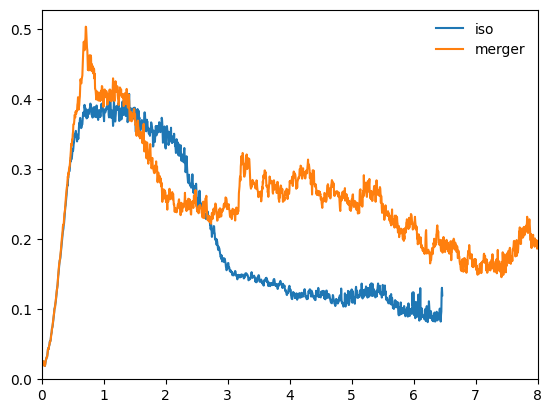

In [31]:
fname = basepath + 'anlys/CGMacc/acc_' + nameiso + '.npy'
f = np.load(fname, allow_pickle=True).item()
l = plt.plot(f['Time'], -f['Mdotin'][:,20], label='iso')
# plt.plot(f['Time'], -f['Mdotout'][:,20], c=l[0].get_color(), ls='dashed')

rGSE = np.linalg.norm(COM['GSE_COM'] - COM['MW_COM'], axis=1)
minima = argrelextrema(rGSE, np.less)
print(minima)

fname = basepath + 'anlys/CGMacc/acc_' + name + '.npy'
f = np.load(fname, allow_pickle=True).item()
l = plt.plot(f['Time'], -f['Mdotin'][:,20], label='merger')
# plt.plot(f['Time'], -f['Mdotout'][:,20], c=l[0].get_color(), ls='dashed')

# fname = basepath + 'anlys/CGMacc/acc_' + namekick + '.npy'
# f = np.load(fname, allow_pickle=True).item()
# plt.plot(f['Time'], f['Mdotin'][:,20], label='gas stripped')

plt.xlim(0, 8)
plt.ylim(0, None)

plt.legend(frameon=False)

(0.0, 138.51818495973322)

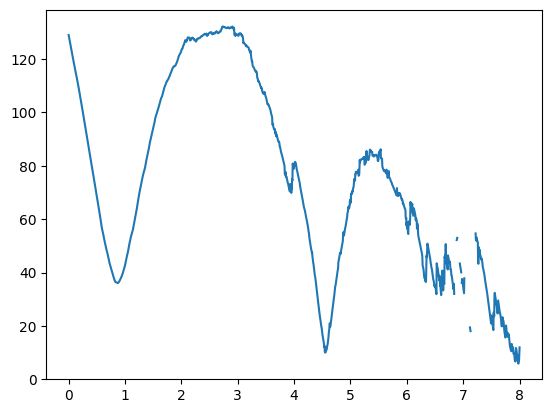

In [34]:
rGSE = np.linalg.norm(COM['GSE_COM'] - COM['MW_COM'], axis=1)
plt.plot(COM['Time'], rGSE)
plt.ylim(0, None)

### Tcut = 4

fname = basepath + 'anlys/CGMacc/acc_' + nameiso + '.npy'
f = np.load(fname, allow_pickle=True).item()
plt.plot(f['Time'], f['Mdotin'][:,0]+f['Mdotout'][:,0], label='iso')

Time = f['Time']
print(np.trapz(-f['Mdotin'][:,0][Time < Tcut] - f['Mdotout'][:,0][Time < Tcut]+f['Menc'][0,0], 
               f['Time'][Time < Tcut]))
print(f['Menc'][int(Tcut*200),0])

fname = basepath + 'anlys/CGMacc/acc_' + name + '.npy'
f = np.load(fname, allow_pickle=True).item()
plt.plot(f['Time'], f['Mdotin'][:,0]+f['Mdotout'][:,0], label='N-body satellite')

Time = f['Time']
print(np.trapz(-f['Mdotin'][:,0][Time < Tcut] - f['Mdotout'][:,0][Time < Tcut]+f['Menc'][0,0], 
               f['Time'][Time < Tcut]))
print(f['Menc'][int(Tcut*200),0])

fname = basepath + 'anlys/CGMacc/acc_' + namekick + '.npy'
f = np.load(fname, allow_pickle=True).item()
plt.plot(f['Time'], f['Mdotin'][:,0]+f['Mdotout'][:,0], label='gas stripped')

Time = f['Time']
print(np.trapz(-f['Mdotin'][:,0][Time < Tcut] - f['Mdotout'][:,0][Time < Tcut]+f['Menc'][0,0], 
               f['Time'][Time < Tcut]))
print(f['Menc'][int(Tcut*200),0])

print(f['Menc'][0,0])
print(f['Mdotin'][200,0])

print(f['r0_list'][0])

plt.legend(frameon=False)

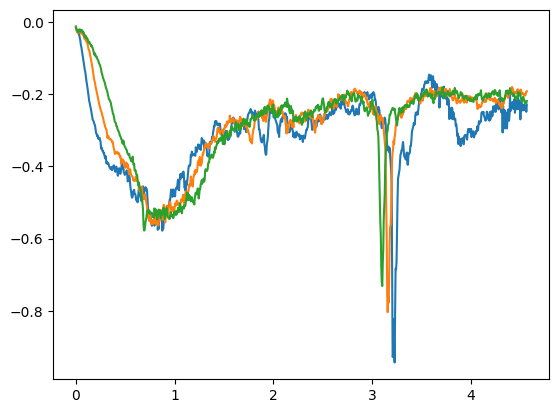

In [40]:
fname = basepath + 'anlys/CGMacc/acc_' + namekick + '.npy'
f = np.load(fname, allow_pickle=True).item()
plt.plot(f['Time'], f['Mdotin'][:,0], label='r = 20')
plt.plot(f['Time'], f['Mdotin'][:,10], label='r = 30')
plt.plot(f['Time'], f['Mdotin'][:,20], label='r = 40')

In [42]:
Time = f['Time']
np.trapz(f['Mdotin'][:,0][Time < 4], f['Time'][Time < 4])

-1.2813502499121308

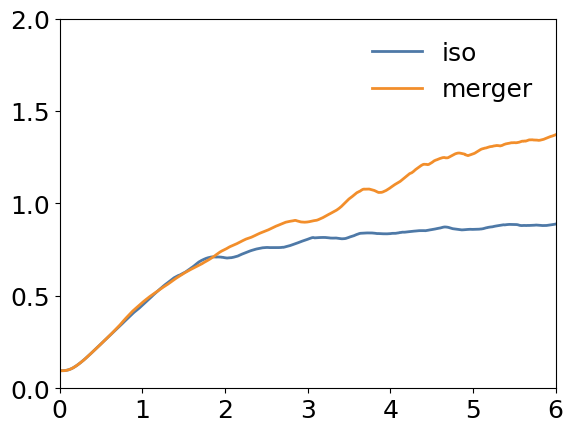

In [41]:
tb_c = ['#4e79a7', '#f28e2b', '#e15759', '#76b7b2', '#59a14f',
        '#edc948', '#b07aa1', '#ff9da7', '#9c755f', '#bab0ac']

plt.rcParams.update({'font.size': 18})

fname = basepath + 'anlys/CGMacc/acc_' + nameiso + '.npy'
f = np.load(fname, allow_pickle=True).item()
plt.plot(f['Time'], f['Menc'][:,0], label='iso', c=tb_c[0], lw=2)

fname = basepath + 'anlys/CGMacc/acc_' + name + '.npy'
f = np.load(fname, allow_pickle=True).item()
plt.plot(f['Time'], f['Menc'][:,0], label='merger', c=tb_c[1], lw=2)

# fname = basepath + 'anlys/CGMacc/acc_' + namekick + '.npy'
# f = np.load(fname, allow_pickle=True).item()
# plt.plot(f['Time'], f['Menc'][:,0], label='gas stripped', c=tb_c[2], lw=2)

plt.xlim(0, 6)
plt.ylim(0, 2)
# plt.xlabel('T [Gyr]')
# plt.ylabel('Menc [1E10 Msun]')

plt.legend(frameon=False)

(0.0, 1.2)

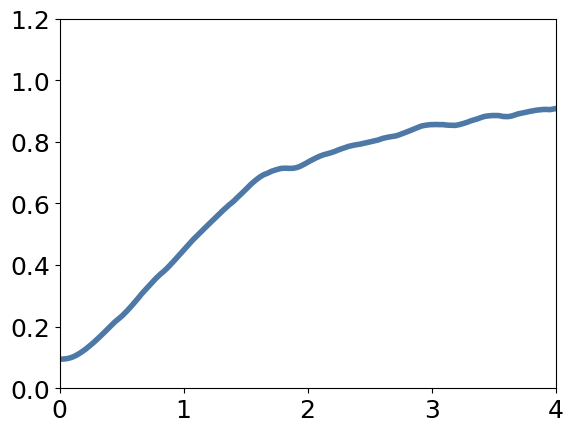

In [335]:
tb_c = ['#4e79a7', '#f28e2b', '#e15759', '#76b7b2', '#59a14f',
        '#edc948', '#b07aa1', '#ff9da7', '#9c755f', '#bab0ac']

plt.rcParams.update({'font.size': 18})

fname = basepath + 'anlys/CGMacc/acc_' + nameiso + '.npy'
f = np.load(fname, allow_pickle=True).item()
plt.plot(f['Time'], f['Menc'][:,0], label='iso', c=tb_c[0], lw=4)

fname = basepath + 'anlys/CGMacc/acc_' + name + '.npy'
f = np.load(fname, allow_pickle=True).item()
# plt.plot(f['Time'], f['Menc'][:,0], label='N-body satellite', c=tb_c[1], lw=4)

fname = basepath + 'anlys/CGMacc/acc_' + namekick + '.npy'
f = np.load(fname, allow_pickle=True).item()
# plt.plot(f['Time'], f['Menc'][:,0], label='gas stripped', c=tb_c[2], lw=4)

plt.xlim(0, 4)
plt.ylim(0, 1.2)
# plt.xlabel('T [Gyr]')
# plt.ylabel('Menc [1E10 Msun]')

# plt.legend(frameon=False)

(0.0, 1.2)

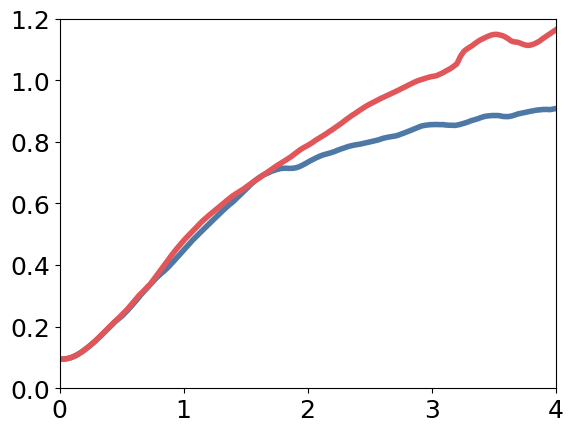

In [336]:
tb_c = ['#4e79a7', '#f28e2b', '#e15759', '#76b7b2', '#59a14f',
        '#edc948', '#b07aa1', '#ff9da7', '#9c755f', '#bab0ac']

plt.rcParams.update({'font.size': 18})

fname = basepath + 'anlys/CGMacc/acc_' + nameiso + '.npy'
f = np.load(fname, allow_pickle=True).item()
plt.plot(f['Time'], f['Menc'][:,0], label='iso', c=tb_c[0], lw=4)

fname = basepath + 'anlys/CGMacc/acc_' + name + '.npy'
f = np.load(fname, allow_pickle=True).item()
# plt.plot(f['Time'], f['Menc'][:,0], label='N-body satellite', c=tb_c[1], lw=4)

fname = basepath + 'anlys/CGMacc/acc_' + namekick + '.npy'
f = np.load(fname, allow_pickle=True).item()
plt.plot(f['Time'], f['Menc'][:,0], label='gas stripped', c=tb_c[2], lw=4)

plt.xlim(0, 4)
plt.ylim(0, 1.2)
# plt.xlabel('T [Gyr]')
# plt.ylabel('Menc [1E10 Msun]')

# plt.legend(frameon=False)

(0.0, 1.2)

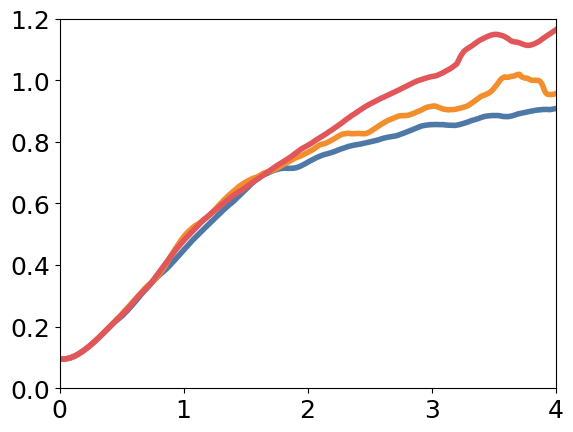

In [337]:
tb_c = ['#4e79a7', '#f28e2b', '#e15759', '#76b7b2', '#59a14f',
        '#edc948', '#b07aa1', '#ff9da7', '#9c755f', '#bab0ac']

plt.rcParams.update({'font.size': 18})

fname = basepath + 'anlys/CGMacc/acc_' + nameiso + '.npy'
f = np.load(fname, allow_pickle=True).item()
plt.plot(f['Time'], f['Menc'][:,0], label='iso', c=tb_c[0], lw=4)

fname = basepath + 'anlys/CGMacc/acc_' + name + '.npy'
f = np.load(fname, allow_pickle=True).item()
plt.plot(f['Time'], f['Menc'][:,0], label='N-body satellite', c=tb_c[1], lw=4)

fname = basepath + 'anlys/CGMacc/acc_' + namekick + '.npy'
f = np.load(fname, allow_pickle=True).item()
plt.plot(f['Time'], f['Menc'][:,0], label='gas stripped', c=tb_c[2], lw=4)

plt.xlim(0, 4)
plt.ylim(0, 1.2)
# plt.xlabel('T [Gyr]')
# plt.ylabel('Menc [1E10 Msun]')

# plt.legend(frameon=False)

## check accretion rate vs inflow rate

In [71]:
snap = 200

fname = basepath + 'anlys/MC/'+namekick+'/MC_Prop_'+str(snap).zfill(3)+'.h5'
f = h5.File(fname, mode='r')
    
pos = f['PartType5/RotatedCoordinates'][:]
vel = f['PartType5/RotatedVelocities'][:]
memb = f['PartType5/Membership'][:]
mass = f['Header'].attrs['TracerMass']
    
r = np.linalg.norm(pos, axis=1)
R = np.linalg.norm(pos[:,:2], axis=1)
cphi = pos[:,0]/R
sphi = pos[:,1]/R
ctheta = pos[:,2]/r
stheta = np.sqrt(1 - ctheta**2)
    
vr = stheta * cphi * vel[:,0] + stheta * sphi * vel[:,1] + ctheta * vel[:,2]
    
Mdotin = []
Mdotout = []
Menc = []

r0 = 20
dr_list = np.linspace(0.1, 4, 100)
for dr in dr_list:
    key = np.logical_and(r > r0 - dr/2., r < r0 + dr/2.)
    key = np.logical_and(key, memb==1)
    keyin = np.logical_and(key, vr < 0)
    keyout = np.logical_and(key, vr > 0)
    
    Mdotin_ = mass * np.sum(vr[keyin]) / dr
    Mdotout_ = mass * np.sum(vr[keyout]) / dr
        
    enc = np.logical_and(r < r0, memb==1)
    Menc_ = mass * len(np.where(enc)[0])
        
    Mdotin.append(Mdotin_)
    Mdotout.append(Mdotout_)
    Menc.append(Menc_)
    
print(Mdotin[99])
    


-0.47207815403313763


In [70]:
-0.47339683025427337

-0.47339683025427337

In [87]:
H = np.random.rand(50, 100)
np.array([H, H, H]).shape

(3, 50, 100)

In [93]:
norm = mpl.colors.LogNorm(vmin=1, vmax=100)
norm.vmin

1.0